# CUDA `rgb_to_gray` refactor

This notebook is dedicated to exploring various refactoring strategies for the initial solution presented by Jeremy Howard in lesson 3. 
The goal is to optimize performance while ensuring the results remain consistent with the original code.

## Setup

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
#!pip install --upgrade torchvision
#!pip install wurlitzer # to add "printf" to cuda kernels
#!pip install testcell

In [3]:
import testcell # Precaution to mitigate the risk of incorrectly assigning the experiment name or note.

In [4]:
#os.environ['CUDA_LAUNCH_BLOCKING']='1'
#%load_ext wurlitzer

In [5]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [6]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [7]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [8]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

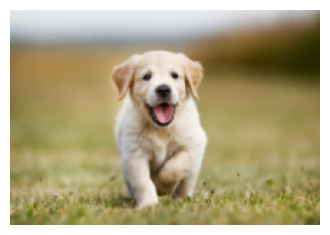

In [9]:
show_img(img2)

In [10]:
experiments = {}

In [11]:
def compare_img(a,b,experiment_name=None,note=None,assert_compare=True,atol=1e-9):
    if assert_compare:
        assert torch.isclose(a,b, atol=atol).all()
    
    import numpy as np
    a = a.numpy().astype(float)
    b = b.numpy().astype(float)
    ae = np.abs((a-b))
    mask = ae>0
    stats = {
        'err_tot' : ae.sum(),
        'err_count' : mask.sum(),
        'err_min' : ae.min(),
        'err_max' : ae.max(),
        'err_pct' : f'{100*mask.sum()/mask.size:.4f}%'
    }
    has_error = ae.sum()>0
    if has_error:
        if experiment_name is not None:
            cur = experiments.get(experiment_name,{})
            cur.update(stats)
            experiments[experiment_name]=cur
        print('Images are different')
        stats_msg = ' | '.join([f'{k}={v}' for k,v in stats.items()])
        if experiment_name is not None:
            stats_msg = f"{experiment_name} : {note}'\n'{stats_msg}"
        plt.figure(figsize=(13,4))
        plt.subplot(1,3,1); plt.imshow(a,cmap='gray'); plt.title('A')
        plt.subplot(1,3,2); plt.imshow(b,cmap='gray'); plt.title('B')
        plt.subplot(1,3,3); plt.imshow(ae,interpolation='nearest'); plt.title('abs(A-B)'); plt.colorbar()
        plt.suptitle(stats_msg)
    else:
        print('Images are identical')

In [12]:
extra_cuda_cflags=[] # no optimizations
#extra_cuda_cflags=["-O2"] # with optimizations

def load_cuda(cuda_src, cpp_src, funcs, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=extra_cuda_cflags, verbose=verbose, name="inline_ext")

In [13]:
# Simulate a "batch" of images
bs = 1

# Simulate batch stacking horizontally more images
if bs==1: bimg = img
else: bimg=torch.cat([img for _ in range(bs)], dim=2)

bimg.shape

torch.Size([3, 1330, 1920])

In [14]:
# Move image to cuda
imgc = bimg.contiguous().cuda() # it's important that memory is contigous

In [15]:
# Benchmark functions
import timeit
from torch.utils.benchmark import Timer

def humanize_time(seconds):
    units = [("s", 1), ("ms", 1e3), ("μs", 1e6), ("ns", 1e9)]
    for unit, factor in units:
        if seconds * factor >= 1:
            return f"{seconds * factor:.2f} {unit}"
    return f"{seconds} s"

def benchmark(experiment_name,stmt,note='',setup='',repeats=10_000):
    print(f'Runnong experiment {experiment_name}:{note} for {repeats} times')
    ret = Timer(
        stmt=stmt,
        setup=setup,
        timer=timeit.default_timer,
        globals=globals(), # catch all globals
    ).timeit(repeats)
    
    # Record experiments on global stats
    if experiment_name is not None:
        data = {'note':note, 'repeats':repeats, 'mean':ret.mean, 
                                  'human_mean':humanize_time(ret.mean),
                                  'stmt':stmt}
        cur = experiments.get(experiment_name,{})
        cur.update(data)
        experiments[experiment_name]=cur
        
    return ret

#t = benchmark(experiment_name='test_01',note='test',stmt='img_gray_original.sum()')

In [16]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

## A: Original code

In [17]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [18]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [19]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [20]:
%%timeit
# original
_ = module.rgb_to_grayscale(imgc)
torch.cuda.synchronize() # ensure all jobs are completed

70.2 µs ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
# original
_ = module.rgb_to_grayscale(imgc).cpu() # move data to cpu

269 µs ± 674 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
img_gray_original = module.rgb_to_grayscale(imgc).cpu()

In [23]:
%%testcell
current_experiment = 'experiment_A'
benchmark(current_experiment,note='original code',stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

Runnong experiment experiment_A:original code for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  70.27 us
  1 measurement, 10000 runs , 1 thread

NOTE: as we can see `benchmark` estimation is pretty close to `%%timeit`: for the sake of automation we'll suppress %%timeit.

In [24]:
# Cleanup
del module

## B: Refactored code

In [25]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(unsigned char r,unsigned char g,unsigned char b) {
    return 0.2989*r + 0.5870*g + 0.1140*b;
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = rgb_to_gray(r,g,b);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [26]:
%%testcell
current_experiment = 'experiment_B'
current_note = 'refactored code separating rgb_to_gray(uchar r, uchar g, uchar b)'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),experiment_name=current_experiment, note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_B:refactored code separating rgb_to_gray(uchar r, uchar g, uchar b) for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  72.60 us
  1 measurement, 10000 runs , 1 thread

In [27]:
#module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [28]:
#%%timeit
## refactored
#_ = module.rgb_to_grayscale(imgc)
#torch.cuda.synchronize() # ensure all jobs are completed

## C: Refactored with struct

In [29]:
cuda_src = cuda_begin + r'''
__device__ struct Color { 
    unsigned char r;
    unsigned char g;
    unsigned char b;
};

// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(Color c) {
    return 0.2989*c.r + 0.5870*c.g + 0.1140*c.b;
}

// indexing
__device__ inline Color get_color_from_chw(unsigned char* x, int n, int i) {
    return {x[i],x[i+n],x[i+2*n]};
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto color = get_color_from_chw(x,n,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [30]:
%%testcell
current_experiment = 'experiment_C'
current_note = 'refactored code with struct: rgb_to_gray(Color c)'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),experiment_name=current_experiment, note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_C:refactored code with struct: rgb_to_gray(Color c) for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  72.18 us
  1 measurement, 10000 runs , 1 thread

## D: Refactored with uchar3

In [31]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(uchar3 c) {
    return 0.2989*c.x + 0.5870*c.y + 0.1140*c.z;
}

// indexing
__device__ inline uchar3 get_color_from_chw(unsigned char* x, int n, int i) {
    return make_uchar3(x[i],x[i+n],x[i+2*n]);
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto color = get_color_from_chw(x,n,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [32]:
%%testcell
current_experiment = 'experiment_D'
current_note = 'refactored code with uchar3: rgb_to_gray(uchar3 c) and indexing get_color_from_chw'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),experiment_name=current_experiment, note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_D:refactored code with uchar3: rgb_to_gray(uchar3 c) and indexing get_color_from_chw for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  72.01 us
  1 measurement, 10000 runs , 1 thread

## E: Refactored with uchar3 and use integer math

In [33]:
cuda_src = cuda_begin + r'''
#define R_FACTOR (77)   // 0.2989 * 256
#define G_FACTOR (150)  // 0.5870 * 256
#define B_FACTOR (29)   // 0.1140 * 256

// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(uchar3 c) {
    return (__umul24(R_FACTOR, c.x) + __umul24(G_FACTOR, c.y) + __umul24(B_FACTOR, c.z)) >> 8;
}

// indexing
__device__ inline uchar3 get_color_from_chw(unsigned char* x, int n, int i) {
    return make_uchar3(x[i],x[i+n],x[i+2*n]);
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto color = get_color_from_chw(x,n,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

Images are different
Runnong experiment experiment_E:refactored code with uchar3 and use integer math to convert to grayscale (shift 8bit) for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  23.66 us
  1 measurement, 10000 runs , 1 thread

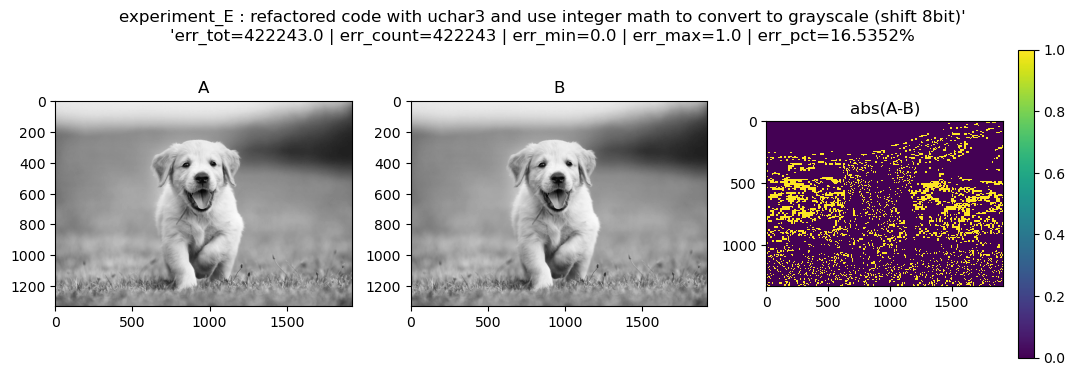

In [34]:
%%testcell
current_experiment = 'experiment_E'
current_note = 'refactored code with uchar3 and use integer math to convert to grayscale (shift 8bit)'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),
            experiment_name=current_experiment, note=current_note, assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

## F: Refactored with uchar3 and use integer math shifting 16 bit

In [35]:
cuda_src = cuda_begin + r'''
#define R_FACTOR (19595)   // round(0.2989 * 65536)
#define G_FACTOR (38470)   // round(0.5870 * 65536)
#define B_FACTOR (7471)    // round(0.1140 * 65536)

// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(uchar3 c) {
    unsigned int gray = __umul24(R_FACTOR, c.x) + __umul24(G_FACTOR, c.y) + __umul24(B_FACTOR, c.z);
    return gray >> 16;
}

// indexing
__device__ inline uchar3 get_color_from_chw(unsigned char* x, int n, int i) {
    return make_uchar3(x[i],x[i+n],x[i+2*n]);
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto color = get_color_from_chw(x,n,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

Images are different
Runnong experiment experiment_F:refactored code with uchar3 and use integer math to convert to grayscale (shift 16bit) for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  23.59 us
  1 measurement, 10000 runs , 1 thread

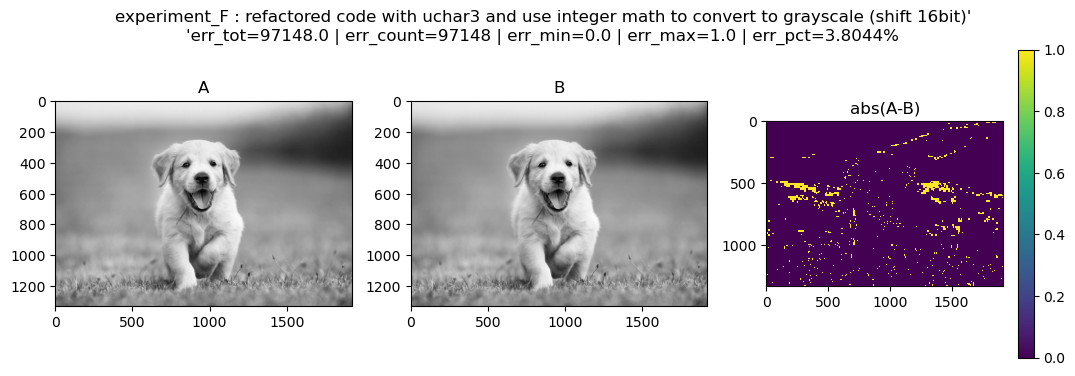

In [36]:
%%testcell
current_experiment = 'experiment_F'
current_note = 'refactored code with uchar3 and use integer math to convert to grayscale (shift 16bit)'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),
            experiment_name=current_experiment, note=current_note, assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

## G: Refactored with uchar3 and rgb_to_gray with fp16

In [37]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton using fp16
#define R_FACTOR 0.2989f
#define G_FACTOR 0.5870f
#define B_FACTOR 0.1140f

__device__ inline unsigned char rgb_to_gray(uchar3 c) {
    __half r_factor = __float2half(R_FACTOR);
    __half g_factor = __float2half(G_FACTOR);
    __half b_factor = __float2half(B_FACTOR);
    __half r = __uint2half_rd(c.x);
    __half g = __uint2half_rd(c.y);
    __half b = __uint2half_rd(c.z);
    return __half2float(__hadd(__hadd(__hmul(r_factor, r) ,  __hmul(g_factor, g)) , __hmul(b_factor, b)));
}

// indexing
__device__ inline uchar3 get_color_from_chw(unsigned char* x, int n, int i) {
    return make_uchar3(x[i],x[i+n],x[i+2*n]);
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto color = get_color_from_chw(x,n,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

Images are different
Runnong experiment experiment_G:refactored code with fp16 in grayscale conversion for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  23.60 us
  1 measurement, 10000 runs , 1 thread

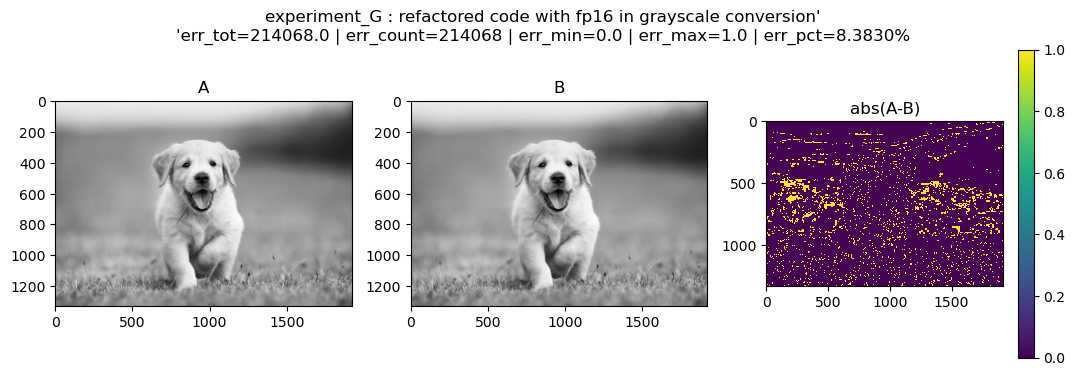

In [38]:
%%testcell
current_experiment = 'experiment_G'
current_note = 'refactored code with fp16 in grayscale conversion'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),
            experiment_name=current_experiment, note=current_note, assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

## H: Refactored non-inlined

In [39]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton
__device__ unsigned char rgb_to_gray(unsigned char r,unsigned char g,unsigned char b) {
    return 0.2989*r + 0.5870*g + 0.1140*b;
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = rgb_to_gray(r,g,b);
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
//    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [40]:
%%testcell
current_experiment = 'experiment_H'
current_note = 'refactored like B but without inline rgb_to_gray'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),
            experiment_name=current_experiment, note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_H:refactored like B but without inline rgb_to_gray for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  73.51 us
  1 measurement, 10000 runs , 1 thread

## I: Rewrite for HWC images

In [41]:
hwc_cuda = imgc.permute([1,2,0]).contiguous().cuda()
hwc_cuda.shape

torch.Size([1330, 1920, 3])

In [42]:
cpp_src_hwc = "torch::Tensor rgb_to_grayscale_hwc(torch::Tensor input);"

In [43]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(unsigned char r,unsigned char g,unsigned char b) {
    return 0.2989*r + 0.5870*g + 0.1140*b;
}

// kernel
__global__ void rgb_to_grayscale_hwc_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i*3];
        auto g = x[i*3+1];
        auto b = x[i*3+2];
        // Compute and modify output
        out[i] = rgb_to_gray(r,g,b);
    }
}

torch::Tensor rgb_to_grayscale_hwc(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(0);
    int w = input.size(1);
    //printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    //printf("threads: %d  blocks: %d\n", threads, blocks);
    rgb_to_grayscale_hwc_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src_hwc, ['rgb_to_grayscale_hwc'])

In [44]:
%%testcell
current_experiment = 'experiment_I'
current_note = 'refactored using hwc tensor and normal reads'
compare_img(img_gray_original,module.rgb_to_grayscale_hwc(hwc_cuda).cpu(),experiment_name=current_experiment,note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale_hwc(hwc_cuda); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_I:refactored using hwc tensor and normal reads for 10000 times


module.rgb_to_grayscale_hwc(hwc_cuda); torch.cuda.synchronize()
  74.33 us
  1 measurement, 10000 runs , 1 thread

## J: Rewrite for HWC images with uchar3

In [45]:
hwc_cuda = imgc.permute([1,2,0]).contiguous().cuda()
hwc_cuda.shape

torch.Size([1330, 1920, 3])

In [46]:
cuda_src = cuda_begin + r'''
// rgb -> gray "pure" funciton
__device__ inline unsigned char rgb_to_gray(uchar3 c) {
    return 0.2989*c.x + 0.5870*c.y + 0.1140*c.z;
}

// indexing: note that now indexing does not depends on "n"
__device__ inline uchar3 get_color_from_chw(uchar3* x, int i) {
    return x[i];
}

// kernel
__global__ void rgb_to_grayscale_hwc_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Casting: doing this on host seems to cause issues
        uchar3* x_as_uchar3 = reinterpret_cast<uchar3*>(x);
        // Indexing
        auto color = get_color_from_chw(x_as_uchar3,i);
        // Compute and modify output
        out[i] = rgb_to_gray(color);
    }
}

torch::Tensor rgb_to_grayscale_hwc(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(0);
    int w = input.size(1);
    //printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    //printf("threads: %d  blocks: %d\n", threads, blocks);
    rgb_to_grayscale_hwc_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, cpp_src_hwc, ['rgb_to_grayscale_hwc'])

In [47]:
%%testcell
current_experiment = 'experiment_J'
current_note = 'refactored using hwc tensor and uchar3 as data type'
compare_img(img_gray_original,module.rgb_to_grayscale_hwc(hwc_cuda).cpu(),experiment_name=current_experiment,note=current_note)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale_hwc(hwc_cuda); torch.cuda.synchronize()')

Images are identical
Runnong experiment experiment_J:refactored using hwc tensor and uchar3 as data type for 10000 times


module.rgb_to_grayscale_hwc(hwc_cuda); torch.cuda.synchronize()
  72.10 us
  1 measurement, 10000 runs , 1 thread

## K: io benchmark
This kernel only read values from 3 channels and sum them together to measure maximum possible speed we can acheive.

In [48]:
cuda_src = cuda_begin + r'''
// kernel
__global__ void io_benchmark_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = r+g+b; // we need to "use" them oherwise optimization may avoid to read the values
    }
}

#define R_FACTOR (0.2989)
#define G_FACTOR (0.5870)
#define B_FACTOR (0.1140)

torch::Tensor io_benchmark(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    // pre compute per-channel float lookup tables
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    io_benchmark_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, 
                   "torch::Tensor io_benchmark(torch::Tensor input);", 
                   ['io_benchmark'])

Images are different
Runnong experiment experiment_K:io benchmark for 10000 times


module.io_benchmark(imgc); torch.cuda.synchronize()
  23.67 us
  1 measurement, 10000 runs , 1 thread

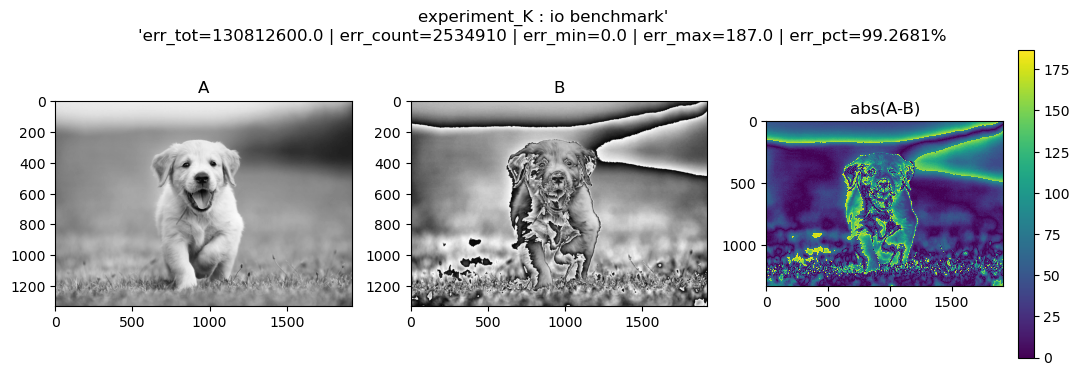

In [49]:
%%testcell
current_experiment = 'experiment_K'
current_note = 'io benchmark'
compare_img(img_gray_original,module.io_benchmark(imgc).cpu(),experiment_name=current_experiment,note=current_note,assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.io_benchmark(imgc); torch.cuda.synchronize()')

## L: per channel float lookup table computed in rgb_to_grayscale
This example pre-compute for each channel on the host all the 256 values.

In [50]:
cuda_src = cuda_begin + r'''
__device__ inline unsigned char rgb_to_gray_lut(unsigned char r,unsigned char g,unsigned char b, float* lut_r, float* lut_g, float* lut_b) {
    return lut_r[r] + lut_g[g] + lut_b[b];
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n, float* lut_r, float* lut_g, float* lut_b) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = rgb_to_gray_lut(r,g,b, lut_r, lut_g, lut_b);
    }
}

#define R_FACTOR (0.2989)
#define G_FACTOR (0.5870)
#define B_FACTOR (0.1140)

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    // pre compute per-channel float lookup tables
    auto lut_r = torch::arange(0, 256, input.options()).to(torch::kFloat) * R_FACTOR;
    auto lut_g = torch::arange(0, 256, input.options()).to(torch::kFloat) * G_FACTOR;
    auto lut_b = torch::arange(0, 256, input.options()).to(torch::kFloat) * B_FACTOR;
    //printf(lut_r);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h,
        lut_r.data_ptr<float>(), lut_g.data_ptr<float>(), lut_b.data_ptr<float>()
        );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, 
                   "torch::Tensor rgb_to_grayscale(torch::Tensor input);", 
                   ['rgb_to_grayscale'])

Images are different
Runnong experiment experiment_L:per channel float lookup table computed in rgb_to_grayscale for 10000 times


module.rgb_to_grayscale(imgc); torch.cuda.synchronize()
  48.09 us
  1 measurement, 10000 runs , 1 thread

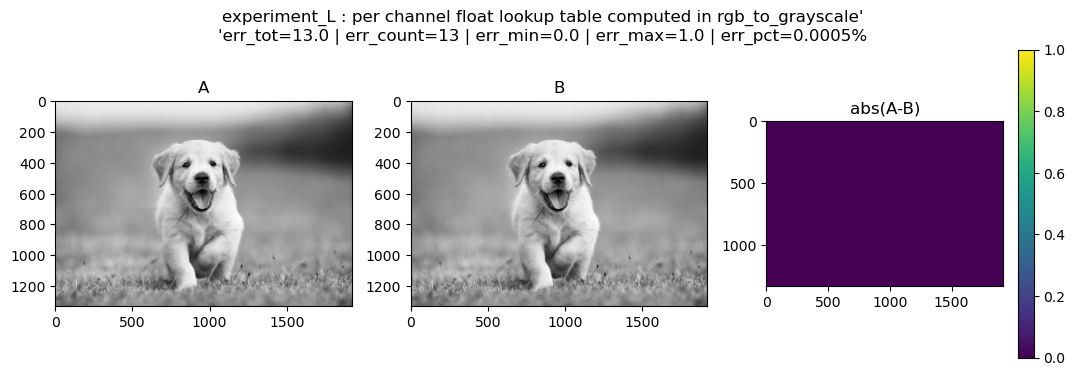

In [51]:
%%testcell
current_experiment = 'experiment_L'
current_note = 'per channel float lookup table computed in rgb_to_grayscale'
compare_img(img_gray_original,module.rgb_to_grayscale(imgc).cpu(),experiment_name=current_experiment,note=current_note,assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale(imgc); torch.cuda.synchronize()')

## M: per channel pre computed float lookup table passed as argument
This example pre-compute for each channel on the host all the 256 values before calling the function.

In [52]:
# Pre compute LUT and move to cuda
lut_rgb = torch.arange(0,256,dtype=torch.float32)[None]*(torch.tensor([0.2989,0.5870,0.1140],dtype=torch.float32).reshape([3,1]))
lut_rgb = lut_rgb.contiguous().cuda()
lut_rgb.shape

torch.Size([3, 256])

In [53]:
cuda_src = cuda_begin + r'''
__device__ inline unsigned char rgb_to_gray_lut(unsigned char r,unsigned char g,unsigned char b, float* lut_rgb) {
    return lut_rgb[r] + lut_rgb[g+256] + lut_rgb[b+256*2];
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n, float* lut_rgb) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = rgb_to_gray_lut(r,g,b, lut_rgb);
    }
}

#define R_FACTOR (0.2989)
#define G_FACTOR (0.5870)
#define B_FACTOR (0.1140)

torch::Tensor rgb_to_grayscale_lut(torch::Tensor input, torch::Tensor lut_rgb) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    //printf(lut_r);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h,lut_rgb.data_ptr<float>());
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, 
                   "torch::Tensor rgb_to_grayscale_lut(torch::Tensor input, torch::Tensor lut_rgb);", 
                   ['rgb_to_grayscale_lut'])

Images are different
Runnong experiment experiment_M:per channel pre computed float lookup table passed as argument for 10000 times


module.rgb_to_grayscale_lut(imgc,lut_rgb); torch.cuda.synchronize()
  25.49 us
  1 measurement, 10000 runs , 1 thread

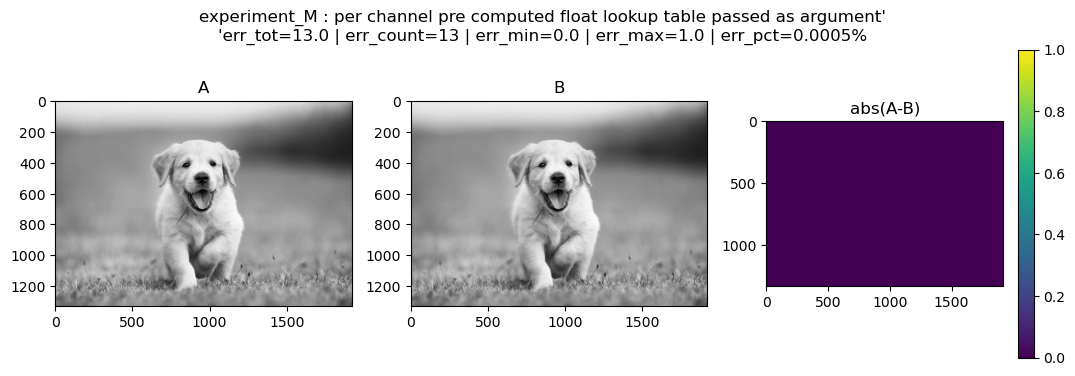

In [54]:
%%testcell
current_experiment = 'experiment_M'
current_note = 'per channel pre computed float lookup table passed as argument'
compare_img(img_gray_original,module.rgb_to_grayscale_lut(imgc,lut_rgb).cpu(),experiment_name=current_experiment,note=current_note,assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale_lut(imgc,lut_rgb); torch.cuda.synchronize()')

## N: per channel pre computed int lookup table
This example pre-compute for each channel on the host all the 256 values as int lookup table before calling the function.

In [55]:
# Pre compute LUT and move to cuda
int32_lut_rgb = (torch.arange(0,256,dtype=torch.int)[None]*(torch.tensor([77,150,29],dtype=torch.int).reshape([3,1]))).to(torch.int32)
int32_lut_rgb = int32_lut_rgb.contiguous().cuda()
int32_lut_rgb.shape, int32_lut_rgb.dtype

(torch.Size([3, 256]), torch.int32)

In [56]:
cuda_src = cuda_begin + r'''
__device__ inline unsigned char rgb_to_gray_lut(unsigned char r,unsigned char g,unsigned char b, int* int32_lut_rgb) {
    return (int32_lut_rgb[r] + int32_lut_rgb[g+256] + int32_lut_rgb[b+256*2]) >> 8;
}

// kernel
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n, int* int32_lut_rgb) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) { // basic check
        // Indexing
        auto r = x[i];
        auto g = x[i+n];
        auto b = x[i+2*n];
        // Compute and modify output
        out[i] = rgb_to_gray_lut(r,g,b, int32_lut_rgb);
    }
}

#define R_FACTOR (0.2989)
#define G_FACTOR (0.5870)
#define B_FACTOR (0.1140)

torch::Tensor rgb_to_grayscale_lut_int32(torch::Tensor input, torch::Tensor int32_lut_rgb) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    //printf(lut_r);
    auto output = torch::empty({h,w}, input.options()); // empty tensor created
    int threads = 256;
    int blocks = cdiv(w*h,threads);
    rgb_to_grayscale_kernel<<<blocks, threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h,int32_lut_rgb.data_ptr<int>());
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

module = load_cuda(cuda_src, 
                   "torch::Tensor rgb_to_grayscale_lut_int32(torch::Tensor input, torch::Tensor int32_lut_rgb);", 
                   ['rgb_to_grayscale_lut_int32'])

Images are different
Runnong experiment experiment_N:per channel pre computed int lookup table for 10000 times


module.rgb_to_grayscale_lut_int32(imgc,int32_lut_rgb); torch.cuda.synchronize()
  25.10 us
  1 measurement, 10000 runs , 1 thread

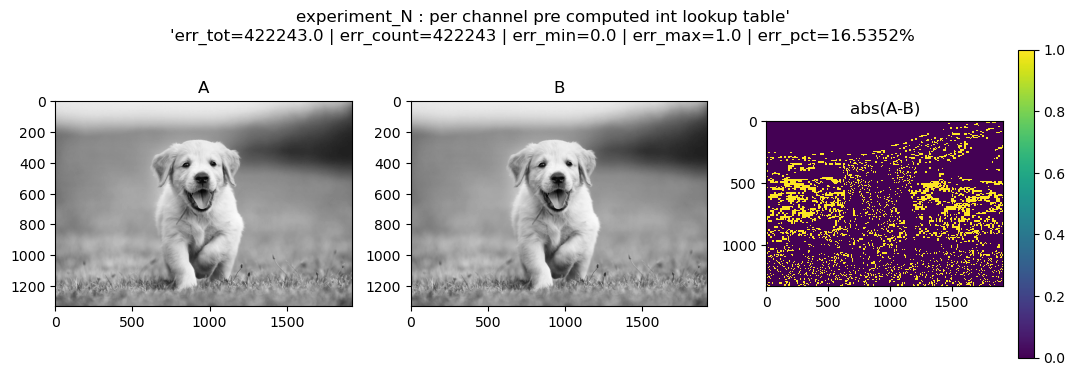

In [57]:
%%testcell
current_experiment = 'experiment_N'
current_note = 'per channel pre computed int lookup table'
compare_img(img_gray_original,module.rgb_to_grayscale_lut_int32(imgc,int32_lut_rgb).cpu(),experiment_name=current_experiment,note=current_note,assert_compare=False)
benchmark(current_experiment,note=current_note,
          stmt='module.rgb_to_grayscale_lut_int32(imgc,int32_lut_rgb); torch.cuda.synchronize()')

## Final stats

In [58]:
import pandas as pd
df = pd.DataFrame(experiments).T
df = df.sort_values('mean',ascending=True)
df['err_pct'] = df['err_pct'].fillna('0%')
df['extra_cuda_cflags'] = ','.join(extra_cuda_cflags)
df[['img_height','img_width']] = img.shape[1:]
df['bs']=bs
df

,note,repeats,mean,human_mean,stmt,err_tot,err_count,err_min,err_max,err_pct,extra_cuda_cflags,img_height,img_width,bs
experiment_F,refactored code with uchar3 and use integer ma...,10000,0.000024,23.59 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,97148.0,97148,0.0,1.0,3.8044%,,1330,1920,1
experiment_G,refactored code with fp16 in grayscale conversion,10000,0.000024,23.60 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,214068.0,214068,0.0,1.0,8.3830%,,1330,1920,1
experiment_E,refactored code with uchar3 and use integer ma...,10000,0.000024,23.66 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,422243.0,422243,0.0,1.0,16.5352%,,1330,1920,1
experiment_K,io benchmark,10000,0.000024,23.67 μs,module.io_benchmark(imgc); torch.cuda.synchron...,130812600.0,2534910,0.0,187.0,99.2681%,,1330,1920,1
experiment_N,per channel pre computed int lookup table,10000,0.000025,25.10 μs,"module.rgb_to_grayscale_lut_int32(imgc,int32_l...",422243.0,422243,0.0,1.0,16.5352%,,1330,1920,1
experiment_M,per channel pre computed float lookup table pa...,10000,0.000025,25.49 μs,"module.rgb_to_grayscale_lut(imgc,lut_rgb); tor...",13.0,13,0.0,1.0,0.0005%,,1330,1920,1
experiment_L,per channel float lookup table computed in rgb...,10000,0.000048,48.09 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,13.0,13,0.0,1.0,0.0005%,,1330,1920,1
experiment_A,original code,10000,0.00007,70.27 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,NaN,NaN,NaN,NaN,0%,,1330,1920,1
experiment_D,refactored code with uchar3: rgb_to_gray(uchar...,10000,0.000072,72.01 μs,module.rgb_to_grayscale(imgc); torch.cuda.sync...,NaN,NaN,NaN,NaN,0%,,1330,1920,1
experiment_J,refactored using hwc tensor and uchar3 as data...,10000,0.000072,72.10 μs,module.rgb_to_grayscale_hwc(hwc_cuda); torch.c...,NaN,NaN,NaN,NaN,0%,,1330,1920,1


In [59]:
with pd.option_context('display.max_colwidth', 100):
    display(df[['note','human_mean','err_pct','extra_cuda_cflags','img_width','img_height','bs']])

,note,human_mean,err_pct,extra_cuda_cflags,img_width,img_height,bs
experiment_F,refactored code with uchar3 and use integer math to convert to grayscale (shift 16bit),23.59 μs,3.8044%,,1920,1330,1
experiment_G,refactored code with fp16 in grayscale conversion,23.60 μs,8.3830%,,1920,1330,1
experiment_E,refactored code with uchar3 and use integer math to convert to grayscale (shift 8bit),23.66 μs,16.5352%,,1920,1330,1
experiment_K,io benchmark,23.67 μs,99.2681%,,1920,1330,1
experiment_N,per channel pre computed int lookup table,25.10 μs,16.5352%,,1920,1330,1
experiment_M,per channel pre computed float lookup table passed as argument,25.49 μs,0.0005%,,1920,1330,1
experiment_L,per channel float lookup table computed in rgb_to_grayscale,48.09 μs,0.0005%,,1920,1330,1
experiment_A,original code,70.27 μs,0%,,1920,1330,1
experiment_D,refactored code with uchar3: rgb_to_gray(uchar3 c) and indexing get_color_from_chw,72.01 μs,0%,,1920,1330,1
experiment_J,refactored using hwc tensor and uchar3 as data type,72.10 μs,0%,,1920,1330,1
